In [2]:
import pandas as pd

import os
from datetime import datetime

from pandas.api.types import CategoricalDtype
import pylab as P

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm, matplotlib.font_manager as fm

import glob
import fnmatch

import collections
import re

import logging

from matplotlib.backends.backend_pdf import PdfPages
pd.set_option('display.max_columns', 1800)
pd.set_option('display.width', 1800)

fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
import datetime
%pylab inline
sns.set(style="darkgrid")
plt.style.use('ggplot')

box=os.getenv('BOX_LOC')

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### Notebook for preparing a few control total files

[regional_controls.csv](https://github.com/BayAreaMetro/bayarea_urbansim/blob/master/data/regional_controls.csv)

[county_employment_forecast.csv](https://github.com/BayAreaMetro/bayarea_urbansim/blob/master/data/county_employment_forecast.csv)

### Define a number of mappings 

In [3]:
INPUT_REMI_PATH = os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI_raw_output')
INPUT_BASEDATA_PATH = os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/household_forecast/base_data')
INPUT_MAPPINGS_PATH = os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/mappings')
OUTPUT_PATH = os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/household_forecast/output')

In [4]:
## geographic mappings

bayareafips_full ={'06001':'Alameda', '06013':'Contra Costa', '06041':'Marin', '06055':'Napa', '06075':'San Francisco', '06081':'San Mateo', '06085':'Santa Clara', '06097':'Sonoma', '06095':'Solano'}

counties_mtc={'Alameda':4,
 'Contra Costa':5,
 'Santa Clara':3,
 'Napa':7,
 'San Mateo':2,
 'San Francisco':1,
 'Sonoma':8,
 'Marin':9,
 'Solano':6}

## mapping for REMI area grouping
bayarearegions={'06001':'East Bay',
 '06013':'East Bay',
 '06085':'South Bay',
 '06055':'North Bay',
 '06081':'West Bay',
 '06075':'West Bay',
 '06097':'North Bay',
 '06041':'West Bay',
 '06095':'North Bay'}

pct=lambda x: x/x.sum()

In [5]:
## map remi occ groups to census major ones--this is dirty, bc the census ones shift.
occ_to_census = {u'Management, business, and financial occupations':'occ_mgmt',
u'Computer, mathematical, architecture, and engineering occupations':'occ_mgmt',
u'Life, physical, and social science occupations':'occ_mgmt',
u'Community and social service occupations':'occ_svcs',
u'Legal occupations':'occ_mgmt',
u'Education, training, and library occupations':'occ_svcs',
u'Arts, design, entertainment, sports, and media occupations':'occ_svcs',
u'Healthcare occupations':'occ_svcs',
u'Protective service occupations':'occ_svcs',
u'Food preparation and serving related occupations':'occ_sls',
u'Building and grounds cleaning and maintenance,personal care and service occupations':'occ_svcs',
u'Sales and related, office and administrative support occupations':'occ_sls',
u'Farming, fishing, and forestry occupations':'occ_nat',
u'Construction and extraction occupations':'occ_nat',
u'Installation, maintenance, and repair occupations':'occ_prod',
u'Production occupations':'occ_prod',
u'Transportation and material moving occupations':'occ_prod',
u'Military':'occ_other'}


In [6]:
## this table is custom generated in REMI--mxing in govt as industry employment

indus_to_census={u'State and Local Government':'ind_public',
u'Federal Civilian':'ind_public',
u'Federal Military':'ind_public',
u'Forestry, Fishing, and Related Activities':'ind_other',
u'Mining':'ind_other',
u'Utilities':'ind_other',
u'Construction':'ind_other',
u'Manufacturing':'ind_other',
u'Wholesale Trade':'ind_other',
u'Retail Trade':'ind_retail',
u'Transportation and Warehousing':'ind_other',
u'Information':'ind_prof',
u'Finance and Insurance':'ind_prof',
u'Real Estate and Rental and Leasing':'ind_prof',
u'Professional, Scientific, and Technical Services':'ind_prof',
u'Management of Companies and Enterprises':'ind_prof',
u'Administrative and Waste Management Services':'ind_other',
                 'Administrative, Support, Waste Management, And Remediation Services':'ind_other',
u'Educational Services':'ind_educ',
u'Educational Services; private':'ind_educ',
u'Health Care and Social Assistance':'ind_health',
u'Arts, Entertainment, and Recreation':'ind_other',
u'Accommodation and Food Services':'ind_accom_food_svcs',
u'Other Services, except Public Administration':'ind_other',
                u'Other Services':'ind_other'}

## mapping that collapses finer to coarser age bins in the remi output

agemapcollapser={u'Ages 0-15':u'Ages 0-15', u'Ages 16-19':u'Ages 16-19', u'Ages 20-21':u'Ages 20-24', u'Ages 22-24':u'Ages 20-24',
 u'Ages 25-29':u'Ages 25-34', u'Ages 30-34':u'Ages 25-34',
 u'Ages 35-44':u'Ages 35-44', u'Ages 45-54':u'Ages 45-54', u'Ages 55-59':u'Ages 55-64',
 u'Ages 60-61':u'Ages 55-64', u'Ages 62-64':u'Ages 55-64', u'Ages 65-69':u'Ages 65+', u'Ages 70-74':u'Ages 65+',
 u'Ages 75+':u'Ages 65+'}
set(agemapcollapser.values())

{u'Ages 0-15',
 u'Ages 16-19',
 u'Ages 20-24',
 u'Ages 25-34',
 u'Ages 35-44',
 u'Ages 45-54',
 u'Ages 55-64',
 u'Ages 65+'}

In [7]:
## mapping to SOC
occ_det_soc_map={'occ_det_mgmt':'11-0000',  ## mgmt
'occ_det_biz':'13-0000',   #  Business and Financial Operations Occupations
'occ_det_comp':'15-0000',   # Computer and Mathematical Occupations
'occ_det_community':'21-0000',  # Community and Social Service Occupations
'occ_det_lgl':'23-0000',  # legal
'occ_det_hlthsup':'31-0000',  # Healthcare Support Occupations
'occ_det_foodprep':'35-0000',  # Food Preparation and Serving Related Occupations
'occ_det_officeadmin':'43-0000'}#,  ## Office and Administrative Support Occupations

occ_det_soc_map={'11-0000': 'occ_det_mgmt',
 '13-0000': 'occ_det_biz',
 '15-0000': 'occ_det_comp',
 '21-0000': 'occ_det_community',
 '23-0000': 'occ_det_lgl',
 '31-0000': 'occ_det_hlthsup',
 '35-0000': 'occ_det_foodprep',
 '43-0000': 'occ_det_officeadmin'}

In [10]:
## convenience label function
def agebreaker(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("Ages {fr}-{to}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='Ages {dt:,.0f}+'.format(dt=breaks[-2])
    return labels
#agebreaker(range(0,86,5))

def agebreaker2(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("Ages {fr:.0f}-{to:.0f}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='Ages {dt:,.0f}+'.format(dt=breaks[-2])
    return labels

def agebreaker_mtc(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("age{fr:02}{to:02}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='age{dt:}p'.format(dt=breaks[-2])
    return labels
breaks_5 =range(0,86,5)+[np.inf]
#diffbreaks_5 =range(0,76,5)+[np.inf]

diffbreaks_custom =[0,5]+range(20,90,5)+[np.inf]
age_coarse=[0,5,15,25,65,inf]
age_mtc=[0,5,20,45,65,inf]


In [11]:
def rounder(s,precision=3):
    factor=10**precision
    out=np.round(s/10**precision,0)*factor
    return out

In [12]:
def classifier(df):
    """
    we need to classify each row with the appropriate hierarchy level.
    for each row, we want to get the rightmost value available--
    that represents the finest grained detail class
    """
    
    x = df.ix[:4].tolist()
    try:
        out = next(s for s in x if not s is np.NaN)
    except:
        out = None
    return  out

def classlevel(s):
    
    try:
        if s[3:]=='0000':
            return 'major'
        elif np.float64(s[3:]) % 100==0:
            return 'minor'
        elif np.float64(s[3:]) % 10==0:
            return 'broad'
        else:
            return 'detail'
    except:
        return 'none'

In [13]:
soc = pd.read_excel(os.path.join(INPUT_MAPPINGS_PATH,'soc_structure_2010.xls'),skiprows=11,
                   names=[u'Major Group', u'Minor Group', u'Broad Group', u'Detailed Occupation', u'Description'])
soc['soc_2']=soc['Major Group']#.fillna('').str.split('-').apply(lambda x: x[0])
soc['class']=soc.ix[:,:4].apply(classifier,axis=1)
soc['hierarchy']=soc['class'].fillna('-1').map(classlevel)
soc['Description']=soc.Description.fillna('0').str.lower()

soc=soc.append(pd.DataFrame(data={'Description':['counselors and social workers'],'soc_2':['21-0000'],'class':['21-0000']}))

soc['soc_2']=soc['soc_2'].fillna(method='ffill')
soc=soc[soc['soc_2'].notnull()]
soc['DescShort']=soc.Description.str.slice(0,8)

### Define dictionaries with scenarios to load
These are used to fetch raw REMI output from disk. Needless to say, they need to be pre-exported first.

In [15]:
BLUEPRINT_RUNS=['R6H2C_COVID_fix','R6H2C_COVID_cross']

In [16]:
scenarios=collections.OrderedDict([#('RC no change 3','RC no change 3'),
          # ('RC5','base_RC2050'),
          # ('R5H0C','H0_RC2050'),
          #  ('R5H1C','H1_RC2050'),
          #  ('R5H2C','H2_RC2050'),
            #('PBA_2040','PBA_2040'),
    
        ## draft blueprint    
        #('RC6','Blueprint Baseline'),
        #('R6H2C_fix','Blueprint Plus Fix it First'),
        #('R6H2C_plus','Blueprint Plus Crossing'),
        #('R6H2C_basic','Blueprint Basic'),

## draft blueprint, with COVID-19 adjustments    
('RC6_COVID','Blueprint-CV19 Baseline'),
('R6H2C_COVID_fix','Blueprint-CV19 Plus Fix it First'),
('R6H2C_COVID_cross','Blueprint-CV19 Plus Crossing'),
('R6H2C_COVID_basic','Blueprint-CV19 Basic')]
)

In [17]:
# scenarios_urbansim=collections.OrderedDict([
#  ('R5H2C','17: Forecast test, less constrained'),
#  ('R6H2C_basic','21: Blueprint Basic'),
#  ('R6H2C_fix','22: Blueprint Plus'),
#  ('R6H2C_plus','23: Blueprint Plus Crossing'),
#  ('RC5','16: Forecast test, base'),
#  ('RC6','20: No Project (Plan Bay Area 2050)')])

scenarios_urbansim=collections.OrderedDict([
 ('R5H2C','17: Forecast test, less constrained'),
 ('R6H2C_COVID_basic','21: Blueprint Basic'),
 ('R6H2C_COVID_fix','22: Blueprint Plus'),
 ('R6H2C_COVID_cross','23: Blueprint Plus Crossing'),
 ('RC5','16: Forecast test, base'),
 ('RC6_COVID','20: No Project (Plan Bay Area 2050)')])



scenarios_boxfoldermap={'R6H2C_COVID_basic':'Forecast 04132020/Blueprint Basic',
'R6H2C_COVID_fix':'Forecast 04132020/Blueprint Plus Fix it First',
'R6H2C_COVID_cross':'Forecast 04132020/Blueprint Crossing',
'RC5':'Draft Forecast Base Case',
'R5H2C':'Draft Forecast Upper Case',
'RC6_COVID':'Forecast 04132020/Blueprint Baseline'}


### Start preparing future RHS data / variables

#### Load REMI data
Updated, February 2020

Since remi 2.3, the export format is a bit different. We have mostly separate files, and mostly, for the big files, segmented by subregion.

Don't put junk files in these folders - we expect only the relevant output files to be there.

In [18]:
matches = []
for root, dirnames, filenames in os.walk(os.path.join(INPUT_REMI_PATH,'population')):
    for filename in fnmatch.filter(filenames, '*.xlsx'):
        matches.append(os.path.join(root, filename))
outdata={}

for fn in matches:
    #print hdr['Forecast']
    #temp=pd.read_excel(matches[0],skiprows=5)

    temp=pd.read_excel(fn,skiprows=2)
    hdr=temp.iloc[0].to_dict()
    
    ## only load file if in scenarios dict defined above
    if hdr['Forecast'].strip() in scenarios:
        print "\tProcessing ",hdr['Forecast']#,hdr['Region']
    
        temp=pd.read_excel(fn,skiprows=5)
#        outdata[(scenarios[hdr['Forecast'].strip()],hdr['Region'].strip())]=temp.set_index(['Race','Gender','Ages']).filter(regex='\d{4}')
        outdata[hdr['Forecast'].strip()]=temp.set_index(['Region','Race','Gender','Ages']).filter(regex='\d{4}')

outdata=pd.concat(outdata)

outdata.index=outdata.index.set_names(['runid'],level=[0])
remipop=(outdata.stack()*1000).round(0).astype(np.int32).reset_index(name='value')

remipop=remipop.rename(columns={'Race':'rac_ethn','level_5':'Year'})
remipop['sex']=remipop.Gender.str.lower()
remipop['age_fine']=pd.cut(remipop.Ages.str.extract('(\d{1,3})',expand=False).astype(int),right=False,bins=diffbreaks_custom,labels=agebreaker(diffbreaks_custom)).astype(str)
remipop['age_grp_5']=pd.cut(remipop.Ages.str.extract('(\d{1,3})',expand=False).astype(np.int32),bins=breaks_5,
           labels=agebreaker2(breaks_5),include_lowest=True,right=False)
remipop['age_grp_coarse']=pd.cut(remipop.Ages.str.extract('(\d{1,3})',expand=False).astype(np.int32),bins=age_coarse,
           labels=agebreaker2(age_coarse),include_lowest=True,right=False)

remipop['age_grp_mtc']=pd.cut(remipop.Ages.str.extract('(\d{1,3})',expand=False).astype(np.int32),bins=age_mtc,
           labels=agebreaker_mtc(age_mtc),include_lowest=True,right=False)

remipop['gender']=remipop.Gender+'s'

	Processing  R6H2C_COVID_basic
	Processing  R6H2C_COVID_cross
	Processing  R6H2C_COVID_fix
	Processing  RC6_COVID


In [98]:
futurepop=remipop.groupby(['runid','Region','Year']).value.sum().unstack('Year')

In [99]:
## create core demographic frames from which to extract specific series

remi_age=remipop.groupby(['runid','Region','Year','age_grp_coarse']).value.sum()#.unstack('Year')
remi_race=remipop.groupby(['runid','Region','Year','rac_ethn']).value.sum()#.unstack('Year')

#### Load labor force frames

In [19]:

matches = []
for root, dirnames, filenames in os.walk(os.path.join(INPUT_REMI_PATH,'labor')):
    for filename in fnmatch.filter(filenames, 'lfpr_gender*.xlsx'):
        matches.append(os.path.join(root, filename))

outlfpr={}
for fn in matches:
    scen=fn.split('/')[-2]
    
    ## only load file if in scenarios dict defined above
    this_scen=fn.split(os.path.sep)[-2]
    if this_scen in scenarios:
        tmplfpr=pd.read_excel(fn,sheet_name='All',skiprows=5)
        ## append scenario consistent with pathname only (file also has comparison / reference scenario - omit here)
        outlfpr[scen]=tmplfpr

outlfpr=pd.concat(outlfpr,names=['runid']).reset_index(1,drop=True).reset_index()
#rv_S_lf_female=outlfpr[outlfpr.Gender=='Female'].set_index(['runid','Region']).filter(regex='\d{4}')

#rv_S_lf=outlfpr[outlfpr.Gender=='Total'].set_index(['runid','Region']).filter(regex='\d{4}')

#### Load labor force data

In [20]:
import fnmatch
matches = []
for root, dirnames, filenames in os.walk(os.path.join(INPUT_REMI_PATH,'labortot')):
    for filename in fnmatch.filter(filenames, '*.xlsx'):
        matches.append(os.path.join(root, filename))

outlf={}
for fn in matches:
    #scen=fn.split('/')[-2]
    
    ## only load file if in scenarios dict defined above
    this_scen=fn.split(os.path.sep)[-2]
    if this_scen in scenarios:
        print fn, scen
        tmplf=pd.read_excel(fn,skiprows=5)
        ## append scenario consistent with pathname only (file also has comparison / reference scenario - omit here)
        outlf[this_scen]=tmplf

outlf=pd.concat(outlf,names=['runid']).reset_index(1,drop=True).reset_index()
## this file ships with Standard Regional Control as well - we don't want to double count
#outlf=outlf[outlf.Forecast!='Standard Regional Control']

/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI_raw_output/labortot/R6H2C_COVID_basic/hhinc 2 labor_age.xlsx RC6_COVID
/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI_raw_output/labortot/R6H2C_COVID_cross/hhinc 2 labor_age.xlsx RC6_COVID
/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI_raw_output/labortot/R6H2C_COVID_fix/hhinc 2 labor_age.xlsx RC6_COVID
/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI_raw_output/labortot/RC6_COVID/hhinc 2 labor_age.xlsx RC6_COVID


In [21]:
## main use is for EMPRES variable for topsheet later
outlf_df=(outlf.set_index(['runid','Region','Ages','Race','Gender']).filter(regex='\d{4}').stack()*1000).reset_index(name='value')
outlf_df=outlf_df.loc[outlf_df.Region.isin(['West Bay','East Bay','North Bay','South Bay'])].rename(columns={'level_5':'year'})

#### Load industry and occupation frames

In [22]:
## read Mike's occ mapping file. 
## Note that SOC 29 is split: Doctors are in "professional", the remainder in "services"

mike_occ_codes=pd.read_csv(os.path.join(INPUT_MAPPINGS_PATH,'emp_occ_codes.csv'),index_col=['Variable','Description']).SOC_codes
mike_occ_codes=mike_occ_codes.str.split(',').apply(pd.Series).stack().reset_index(2,drop=True).str.strip()
mike_occ_codes.head()

Variable              Description          
shr_occ_management    Management Occupation    11
                      Management Occupation    13
shr_occ_professional  Professional             15
                      Professional             17
                      Professional             19
dtype: object

In [23]:
# ## we don't actually use this now - this is by subregion - Mike's control file uses county level occup data

# matches = []
# for root, dirnames, filenames in os.walk(os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI_raw_output/employment')):
#     for filename in fnmatch.filter(filenames, 'hhinc 4 emp occ indus.xlsx'):
#         matches.append(os.path.join(root, filename))


# outocc=[]
# outindus=[]
# for fn in matches:
#     this_scen=fn.split('/')[-2]
#     if this_scen in scenarios:
    
#         tmpocc=pd.read_excel(fn,sheet_name='Occupations',skiprows=4)
#         tmpind=pd.read_excel(fn,sheet_name='Employment by Industry',skiprows=4)
#         ## append scenario consistent with pathname only (file also has comparison / reference scenario - omit here)
#         outocc.append(tmpocc[tmpocc.Forecast==this_scen])
#         outindus.append(tmpind[tmpind.Forecast==this_scen])

# outocc=pd.concat(outocc)
# outindus=pd.concat(outindus)

In [24]:
# ## Load occupation employment by scenario, sub-region
# ## Note: invariably fails to run the first time, with `remove_unused_levels` error. Second time always works.

# outocc.loc[~outocc.Occupations.str.match(r'\s+'),'major_group']=outocc.loc[~outocc.Occupations.str.match(r'\s+')].Occupations
# outocc.loc[outocc.Occupations.str.match(r'\s+'),'detail']=outocc.loc[outocc.Occupations.str.match(r'\s+')].Occupations.str.strip()
# outocc['soc_2']=outocc.Occupations.str.lower().str.strip().map(soc.groupby('Description')['soc_2'].first())

# outocc['occup_grp']=outocc.major_group.map(occ_to_census)
# outocc['occup_grp_det']=outocc.soc_2.map(occ_det_soc_map)
# outocc['occup_grp_det']=outocc['occup_grp_det'].fillna('Other Occupations')

# outocc.major_group=outocc.major_group.fillna(method='ffill')
# outocc=outocc[outocc.detail.notnull()]


# empoccup_pct=outocc.groupby(['Forecast','Region','occup_grp']).sum().stack().groupby(level=[0,1,3]).apply(pct).unstack(3)

# empoccup_det_pct=outocc.groupby(['Forecast','Region','occup_grp_det']).sum().stack().groupby(level=[0,1,3]).apply(pct).unstack(3)

# #empoccup_det_pct.T['R6H2C_COVID_basic'].plot()

In [25]:
# ## Load industry employment by scenario, sub-region

# outindus['naics']=outindus.Industries.str.extract("\(([0-9_\-,]+)\)")
# outindus['industry_name']=outindus.Industries.str.split('(').apply(lambda x: x[0]).str.strip().str.title()
# ## keep only records with 2-digit detail
# outindus=outindus.loc[outindus.naics.fillna('').str.contains('^\d{2}$|^\d{2}-\d{2}$')]
# outindus['indus_grp']=outindus.industry_name.map(dict(zip(map(lambda x: x.title(),indus_to_census.keys()), indus_to_census.values())))

# empindus_pct=outindus.groupby(['Forecast','Region','indus_grp']).sum().stack().groupby(level=[0,1,3]).apply(pct).unstack(3)

#### Get county-level occupation data

In [26]:
import fnmatch
matches = []
for root, dirnames, filenames in os.walk(os.path.join(INPUT_REMI_PATH,'indus_occup')):
    for filename in fnmatch.filter(filenames, 'B4b*'):
        matches.append(os.path.join(root, filename))


outocc_cnty=[]
outindus_cnty=[]
for fn in matches:
    this_scen=fn.split('/')[-2]
    if this_scen in scenarios:
    
        tmpocc=pd.read_excel(fn,sheet_name='Occupations',skiprows=4)
        tmpind=pd.read_excel(fn,sheet_name='Employment by Industry',skiprows=4)
        ## append scenario consistent with pathname only (file also has comparison / reference scenario - omit here)
        outocc_cnty.append(tmpocc[tmpocc.Forecast==this_scen])
        outindus_cnty.append(tmpind[tmpind.Forecast==this_scen])

outocc_cnty=pd.concat(outocc_cnty)
outindus_cnty=pd.concat(outindus_cnty)

In [27]:
## For ## https://github.com/BayAreaMetro/bayarea_urbansim/blob/master/data/county_employment_forecast.csv

outocc_cnty.loc[~outocc_cnty.Occupations.str.match(r'\s+'),'major_group']=outocc_cnty.loc[~outocc_cnty.Occupations.str.match(r'\s+')].Occupations
outocc_cnty['soc_2']=outocc_cnty.Occupations.str.lower().str.strip().str.slice(0,8).map(soc.groupby('DescShort')['soc_2'].first())

## the detail occupations have whitespace in front. We use that for classification purposes
outocc_cnty.loc[outocc_cnty.Occupations.str.match(r'\s+'),'detail']=outocc_cnty.loc[outocc_cnty.Occupations.str.match(r'\s+')].Occupations.str.strip()

## drop summary level
#outocc_cnty=outocc_cnty[outocc_cnty.detail.notna()]

## add mike's codes
outocc_cnty['occ_urbsim']=outocc_cnty.soc_2.str.slice(0,2).map(mike_occ_codes.reset_index(name='value').groupby('value').Variable.first())
outocc_cnty.loc[outocc_cnty.Occupations.str.contains('Milit'),'occ_urbsim']='shr_occ_military'

## override non-docs for SOC 29 as services
outocc_cnty.loc[~(outocc_cnty.detail.fillna('').str.contains('Health diagnosing and treating practitioners'))
               &(outocc_cnty.fillna('').soc_2=='29-0000'),'occ_urbsim']='shr_occ_services'

outocc_cnty['county']=outocc_cnty.Region.map(counties_mtc)
outocc_cnty=outocc_cnty[outocc_cnty.occ_urbsim.notna()]
outocc_cnty=outocc_cnty.loc[((outocc_cnty.major_group=='Military')
                           |(outocc_cnty.major_group.isnull()))]



outocc_cnty_pct=outocc_cnty.groupby(['Forecast','county','Region','occ_urbsim']).sum().stack().groupby(level=['Forecast','county','Region',4]).apply(pct)
outocc_cnty_pct=outocc_cnty_pct.unstack('occ_urbsim').reset_index().rename(columns={'Region':'county_name','Forecast':'runid','level_3':'year'})
outocc_cnty_pct.head(2)

occ_urbsim,runid,county,county_name,year,shr_occ_management,shr_occ_manual,shr_occ_military,shr_occ_professional,shr_occ_retail,shr_occ_services
0,R6H2C_COVID_basic,1,San Francisco,2001,0.252109,0.221687,0.002308,0.232822,0.152558,0.138516
1,R6H2C_COVID_basic,1,San Francisco,2002,0.244957,0.225228,0.002409,0.236051,0.152758,0.138598


In [28]:
## Load misc income output - also not currently needed

matches = []
for root, dirnames, filenames in os.walk(os.path.join(INPUT_REMI_PATH,'income')):
    for filename in fnmatch.filter(filenames, 'misc income.xlsx'):
        matches.append(os.path.join(root, filename))


outincome=[]

for fn in matches:
    
    this_scen=fn.split('/')[-2]
    if this_scen in scenarios:
        print this_scen
        tmp=pd.read_excel(fn,skiprows=5)
        ## append scenario consistent with pathname only (file also has comparison / reference scenario - omit here)
        outincome.append(tmp[tmp.Forecast==this_scen])

outincome=pd.concat(outincome).set_index(['Forecast','Region','Category','Units']).filter(regex='\d{4}')

## turn into true values
outincome.loc(0)[:,:,:,'Thousands']*=1000
outincome.loc(0)[:,:,:,'Billions of Fixed (2009) Dollars']*=1e9

R6H2C_COVID_basic
R6H2C_COVID_cross
R6H2C_COVID_fix
RC6_COVID


In [29]:

real_pers_inc=outincome.loc(0)[:,:,'Personal Income'].reset_index(level=['Category','Units'],drop=True)

real_pers_inc_per_cap=outincome.loc(0)[:,:,'Personal Income'].reset_index(level=['Category','Units'],drop=True)/\
outincome.loc(0)[:,:,'Total Population'].reset_index(level=['Category','Units'],drop=True)
real_pers_inc_per_cap.head(2)

2001          2002          2003          2004          2005          2006          2007          2008          2009          2010          2011          2012          2013          2014          2015          2016          2017          2018          2019          2020          2021          2022          2023          2024          2025          2026          2027           2028           2029           2030           2031           2032           2033           2034           2035           2036           2037           2038           2039           2040           2041           2042           2043           2044           2045           2046           2047           2048           2049           2050
Forecast          Region                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
R6H2C_COVID_basic West Bay   64159.710436  60598.292136  60339.940873  63159.318210  67032.087782  72034.664526  72867.890432  70452.107454  66801.559002  67465.867308  70742.950982  75629.476897  74844.297319  79949.458081  86170.908058  88300.403571  91050.454114  93628.745454  95890.214925  88314.162400  90103.827407  91767.951548  92435.976775  93322.115892  94435.572051  97081.318849  99862.375207  103019.505670  106325.113540  109401.104632  110272.657567  111330.273400  112489.431509  113767.041322  115141.686415  116572.814041  118021.250886  119538.531251  121095.031403  122695.999117  124229.903600  125919.427095  127677.840244  129517.461862  131425.792831  133402.114091  135451.383687  137582.064688  139791.131503  142067.809795
                  South Bay  54475.173139  50818.688443  50418.228890  50708.358933  52095.132177  55416.481630  57271.577379  54689.834885  51212.760158  53486.318227  56371.201257  60515.706859  59243.681797  63045.183135  68395.976448  72123.656491  74917.163750  77477.517139  79829.478267  73935.996491  74966.570236  76428.401360  77147.438970  78182.616402  79479.495259  82277.301871  85069.986932   88330.094619   91691.074786   94815.158916   95876.556450   97085.273512   98358.992730   99682.434329  101073.211119  102489.791368  103899.500758  105322.750656  106755.968560  108204.158971  109600.977707  111083.570481  112615.115517  114206.944242  115861.051582  117582.845495  119373.450043  121224.270401  123144.626567  125119.219613

## Prep controls and outputs

In [31]:
years_out=range(2010,2051,1)
years_out_5=range(2010,2051,5)

In [32]:
YEARS_OUT_1=range(2010,2051,1)
YEARS_OUT_1_2015=range(2015,2051,1)
YEARS_OUT_5=range(2010,2051,5)
YEARS_OUT_5_2015=range(2015,2051,5)

In [33]:
input_path=os.path.join(box,'EDF Shared work/futures/future round2/models v2')
output_path = os.path.join(box,'Modeling and Surveys/Regional Modeling/Housing/PBA50 Housing/PBA50 Household Forecast')

In [34]:
#xlsdata=pd.ExcelWriter(os.path.join(output_path,'topsheet_{:%Y%m%d_%H_%M}.xlsx'.format(datetime.datetime.now())))

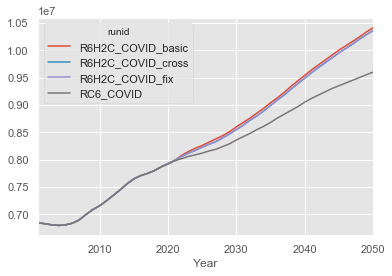

In [35]:
remipop.groupby(['runid','Year']).value.sum().apply(rounder,precision=4).unstack(0).plot()

In [39]:
## RACE

## create core demographic frames from which to extract specific series

remi_age=remipop.groupby(['runid','Region','Year','age_grp_coarse']).value.sum()#.unstack('Year')
remi_race=remipop.groupby(['runid','Region','Year','rac_ethn']).value.sum()#.unstack('Year')

remi_race.groupby(level=['runid','Year','rac_ethn']).sum().loc[:,YEARS_OUT_5].groupby(level=['runid','Year']).apply(pct).unstack('Year')#.to_excel(xlsdata,'race')
remi_age.groupby(level=['runid','Year','age_grp_coarse']).sum().loc[:,years_out].groupby(level=['runid','Year']).apply(pct).unstack('Year')#.to_excel(xlsdata,'age_grp_coarse')

remi_age.sum(level=[0,2]).loc[:,years_out].unstack(1)#.to_excel(xlsdata,'population')

Year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
runid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
R6H2C_COVID_basic,7167026,7255420,7354912,7459008,7562687,7655589,7716461,7756152,7801842,7870746,7934700,7995979,8082200,8150602,8210210,8268158,8326103,8382433,8446989,8518676,8600678,8683644,8769100,8855805,8946732,9041821,9139407,9239071,9340316,9443151,9547155,9645088,9738527,9828421,9915730,10001046,10084953,10167718,10249503,10330584,10410830
R6H2C_COVID_cross,7167026,7255420,7354912,7459008,7562687,7655589,7716461,7756152,7801842,7870746,7934700,7992128,8067520,8126878,8179077,8231283,8285094,8338537,8401205,8471771,8553281,8635985,8721214,8807659,8898273,8993008,9090347,9189692,9290763,9393514,9497486,9595482,9689092,9779221,9866744,9952310,10036405,10119442,10201496,10282824,10363272
R6H2C_COVID_fix,7167026,7255420,7354912,7459008,7562687,7655589,7716461,7756152,7801842,7870746,7934700,7992251,8067428,8126606,8178607,8230684,8284504,8337986,8400779,8471454,8553136,8636004,8721410,8807942,8898719,8993564,9090985,9190408,9291508,9394330,9498392,9596473,9690135,9780270,9867804,9953462,10037530,10120569,10202579,10283956,10364366
RC6_COVID,7167026,7255420,7354912,7459008,7562687,7655589,7716461,7756152,7801842,7870533,7928942,7982257,8025977,8062978,8096188,8127829,8162273,8199104,8244071,8297736,8361290,8424318,8488543,8552631,8619583,8689485,8760692,8832866,8905738,8979299,9053322,9121160,9184277,9243661,9300183,9354746,9407507,9458988,9509204,9558447,9606673


#### Prep median age from finely binned data

In [40]:
remipop['age_num']=remipop.Ages.str.extract('(\d{1,3})').astype(int)

In [41]:
remipop_age_pct=remipop.groupby(['runid','Year','age_num']).value.sum().loc[:,years_out].groupby(level=[0,1]).apply(pct).unstack('age_num')
agepop_cumsum=remipop_age_pct.cumsum(axis=1)
agepop_cumsum.head(2)

age_num                      0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16        17        18        19        20        21        22        23        24       25        26        27        28        29        30        31        32        33        34        35        36        37        38        39        40        41        42        43        44        45        46        47        48        49        50        51        52        53        54        55        56        57        58        59        60        61        62        63        64        65        66        67        68        69        70        71        72        73        74        75        76        77        78        79        80        81        82        83        84        85        86        87        88        89        90        91        92        93        94        95        96        97        98        99   100
runid             Year                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
R6H2C_COVID_basic 2010  0.012253  0.024519  0.037240  0.049933  0.062449  0.075071  0.087640  0.100024  0.112037  0.124239  0.136452  0.148351  0.160255  0.172229  0.184229  0.196634  0.209264  0.221951  0.234634  0.246873  0.259512  0.271895  0.284452  0.297508  0.311201  0.32574  0.340232  0.355113  0.370212  0.385098  0.400776  0.415337  0.429753  0.444188  0.458375  0.473219  0.487619  0.502087  0.516818  0.532206  0.548471  0.563646  0.578292  0.592549  0.606998  0.622364  0.637824  0.653269  0.668389  0.683515  0.699061  0.713733  0.728337  0.742748  0.756759  0.770805  0.784136  0.797072  0.809427  0.821428  0.833563  0.845085  0.856278  0.867732  0.876525  0.885164  0.893235  0.901181  0.908168  0.914579  0.920818  0.926668  0.932290  0.937487  0.942419  0.947221  0.951614  0.955916  0.960036  0.964062  0.968041  0.971633  0.975093  0.978378  0.981462  0.984388  0.987072  0.989467  0.991604  0.993482  0.995027  0.996153  0.997116  0.997858  0.998462  0.998910  0.999266  0.999518  0.999696  0.999805  1.0
                  2011  0.012199  0.024314  0.036483  0.049088  0.061676  0.074265  0.086725  0.099149  0.111392  0.123273  0.135504  0.147585  0.159348  0.171102  0.182955  0.195022  0.207315  0.219836  0.232219  0.243953  0.256265  0.269044  0.281700  0.294765  0.308337  0.32251  0.337331  0.352031  0.367039  0.382257  0.397269  0.412926  0.427535  0.441875  0.456249  0.470448  0.485166  0.499419  0.513735  0.528318  0.543636  0.559657  0.574653  0.589137  0.603217  0.617589  0.632744  0.648044  0.663273  0.678182  0.693179  0.708474  0.722934  0.737301  0.751479  0.765320  0.779098  0.792202  0.804901  0.817013  0.828811  0.840688  0.851949  0.862885  0.874065  0.882694  0.891101  0.898981  0.906710  0.913524  0.919766  0.925842  0.931527  0.936981  0.942015  0.946790  0.951406  0.955628  0.959752  0.963702  0.967540  0.971313  0.974721  0.977959  0.981026  0.983888  0.986571  0.989007  0.991156  0.9930

In [42]:
interval_begin=np.arange(0,100)
interval_end=np.arange(1,101)-.001

In [43]:
## loop through percentiles of interest

percentiles=[.5]
percentiledata={}

for p in percentiles:
    agepop_cumsum['middle_bin_start']=agepop_cumsum.apply(lambda x: interval_begin[np.searchsorted(x,p,side='left').min()-1],axis=1)
    agepop_cumsum['middle_bin_start_share']=agepop_cumsum.apply(lambda x: x[np.searchsorted(x,p,side='left').min()-1],axis=1)
    agepop_cumsum['middle_bin_end']=agepop_cumsum.apply(lambda x: interval_end[np.searchsorted(x,p,side='left').min()-1],axis=1)
    agepop_cumsum['median']=agepop_cumsum.apply(lambda x: x.middle_bin_start+(p-x.middle_bin_start_share)*x.middle_bin_start,axis=1)
    #print agepop_cumsum['median'].head()
    topsheet_age=agepop_cumsum['median'].unstack(1)
    percentiledata['p_{:02.0f}'.format(p*100)]=topsheet_age
pop_age_medians=pd.concat(percentiledata,axis=0,names=['percentile']).stack().unstack([1,0])
pop_age_medians.head(2)

runid,R6H2C_COVID_basic,R6H2C_COVID_cross,R6H2C_COVID_fix,RC6_COVID
percentile,p_50,p_50,p_50,p_50
Year,,,,
2010,36.445706,36.445706,36.445706,36.445706
2011,37.021480,37.021480,37.021480,37.021480


Text(0.5,1,'Median Age, by REMI variant\nSource: ABAG/MTC staff, from REMI')

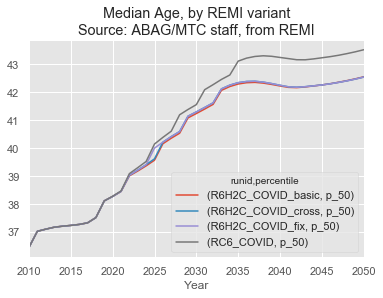

In [44]:
pop_age_medians.plot()
title('Median Age, by REMI variant\nSource: ABAG/MTC staff, from REMI')

In [45]:
#pop_age_medians.to_excel(xlsdata,'age_median')

In [46]:
## set general BEA to BLS scale factor

#BEA_SCALE=1.25

In [47]:
#(outocc.loc[(outocc.Region.isin(['East Bay','West Bay','North Bay','South Bay']))].groupby(['Forecast','major_group']).sum().filter(regex='\d{4}').stack().loc[:,:,years_out].unstack(2)*1e3/BEA_SCALE).round(0).astype(int64).to_excel(xlsdata,'emp_occup')

In [48]:
#(outindus.loc[(outindus.Region.isin(['East Bay','West Bay','North Bay','South Bay']))].groupby(['Forecast','indus_grp']).sum().filter(regex='\d{4}').stack().loc[:,:,years_out].unstack(2)*1e3/BEA_SCALE).round(0).astype(int64).to_excel(xlsdata,'emp_indus')

In [49]:
#xlsdata.close()

## Prepare control total dataframes

### A:  `regional_controls.csv` file


In [50]:
## target schema
controls_schema=['year','totpop','empres','medianage','age0004','age0519','age2044','age4564','age65p','st_res_vac']

In [51]:
controls_medianage=pop_age_medians.stack(level=[0,1]).reset_index('percentile',drop=True).reorder_levels(['runid','Year'])
controls_medianage.index=controls_medianage.index.set_names('year',level=1)
controls_medianage=controls_medianage.to_frame('medianage')
controls_medianage.head(2)

,,medianage
runid,year,
R6H2C_COVID_basic,2010,36.445706
R6H2C_COVID_cross,2010,36.445706


In [52]:
controls_empres=outlf_df.groupby(['runid','year']).value.sum().to_frame(name='empres')
controls_empres.head(2)

empres
runid             year              
R6H2C_COVID_basic 2001  3.751163e+06
                  2002  3.659439e+06

In [53]:
controls_age=remipop.groupby(['runid','Year','age_grp_mtc']).value.sum().unstack('age_grp_mtc').loc(0)[:,years_out]
controls_age.index=controls_age.index.set_names('year',level=1)
controls_age.head()

age_grp_mtc             age0004  age0519  age2044  age4564   age65p
runid             year                                             
R6H2C_COVID_basic 2010   447576  1321767  2581031  1931701   884951
                  2011   447482  1322502  2606610  1965115   913711
                  2012   444148  1327335  2643536  1980046   959847
                  2013   442881  1333257  2681245  1999941  1001684
                  2014   442627  1335739  2720175  2020131  1044015

In [54]:
controls_pop=controls_age.sum(axis=1).to_frame(name='totpop')
controls_pop.index=controls_pop.index.set_names('year',level=1)
controls_pop.head(6)

totpop
runid             year         
R6H2C_COVID_basic 2010  7167026
                  2011  7255420
                  2012  7354912
                  2013  7459008
                  2014  7562687
                  2015  7655589

In [55]:
pd.options.display.float_format = '{:,.4f}'.format
vac_acs=pd.read_csv(os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/household_forecast/base_data/acs_limited_vacancy_2018_2018.csv'),index_col=1).value
vac_acs

# controls_vacancy_rates=pd.concat([pd.Series(.017,index=range(2015,2020)),
#            pd.Series(np.linspace(start=.017,stop=.05,num=11),index=range(2020,2031)),
#            pd.Series(.05,index=range(2031,2051))])

## Extend vacancy rates into the future - converge at 2030 at 5%

controls_vacancy_rates=pd.concat([vac_acs[:-1],
           pd.Series(np.linspace(start=.0221,stop=.05,num=13),index=range(2018,2031)),
           pd.Series(.05,index=range(2031,2051))])

controls_vacancy_rates.index=controls_vacancy_rates.index.set_names('year')
controls_vacancy_rates.name='st_res_vac'
controls_vacancy_rates.head(12)

year
2010   0.0323
2011   0.0260
2012   0.0229
2013   0.0191
2014   0.0163
2015   0.0141
2016   0.0171
2017   0.0193
2018   0.0221
2019   0.0244
2020   0.0268
2021   0.0291
Name: st_res_vac, dtype: float64

In [56]:
regional_controls=pd.concat([controls_medianage,controls_pop,controls_empres,controls_age],axis=1).reorder_levels(['year','runid']).join(controls_vacancy_rates)
regional_controls=regional_controls.loc[years_out].reset_index()

regional_controls['scenario_urbansim']=regional_controls.runid.map(scenarios_urbansim)
regional_controls=regional_controls[regional_controls.runid.isin(scenarios_urbansim)]
regional_controls=regional_controls.set_index(['runid','scenario_urbansim']).loc[:,controls_schema]


regional_controls[[u'year', u'totpop', u'empres', u'age0004', u'age0519', u'age2044', u'age4564', u'age65p']]=regional_controls[[u'year', u'totpop', u'empres', u'age0004', u'age0519', u'age2044', u'age4564', u'age65p']].round(0).astype(int)
regional_controls.update(regional_controls[[u'medianage',u'st_res_vac' ]].round(3).astype(float))

regional_controls=regional_controls[regional_controls.year.isin(YEARS_OUT_5)]

In [57]:
## write to CSV files on box

for nme, dta in regional_controls.groupby(level=['runid','scenario_urbansim']):
    print nme
    dta.to_csv(os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/{pth}/regional_controls_s{fl}.csv'.format(pth=scenarios_boxfoldermap[nme[0]],fl=nme[1][:2])))
    

('R6H2C_COVID_basic', '21: Blueprint Basic')
('R6H2C_COVID_cross', '23: Blueprint Plus Crossing')
('R6H2C_COVID_fix', '22: Blueprint Plus')
('RC6_COVID', '20: No Project (Plan Bay Area 2050)')


### B: `county_employment_forecast.csv` file
https://github.com/BayAreaMetro/bayarea_urbansim/blob/master/data/county_employment_forecast.csv

In [58]:
outocc_cnty_pct_df=outocc_cnty_pct.copy()
outocc_cnty_pct_df['scenario_urbansim']=outocc_cnty_pct_df.runid.map(scenarios_urbansim)

outocc_cnty_pct_df=outocc_cnty_pct_df[[u'runid', u'scenario_urbansim', u'county', u'county_name', u'year', u'shr_occ_management', u'shr_occ_manual', u'shr_occ_professional', u'shr_occ_retail', u'shr_occ_services','shr_occ_military']]
outocc_cnty_pct_df=outocc_cnty_pct_df.set_index([u'runid', u'scenario_urbansim', u'county', u'county_name', u'year'])
outocc_cnty_pct_df=outocc_cnty_pct_df.loc(0)[:,:,:,:,years_out_5].round(5)
outocc_cnty_pct_df.head(2)

occ_urbsim                                                       shr_occ_management  shr_occ_manual  shr_occ_professional  shr_occ_retail  shr_occ_services  shr_occ_military
runid             scenario_urbansim   county county_name   year                                                                                                              
R6H2C_COVID_basic 21: Blueprint Basic 1      San Francisco 2010              0.2478          0.2154                0.2418          0.1546            0.1380            0.0024
                                                           2015              0.2602          0.2146                0.2362          0.1542            0.1330            0.0018

In [59]:
for nme, dta in outocc_cnty_pct_df.groupby(level=['runid','scenario_urbansim']):
    print nme
    dta.to_csv(os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/{pth}/county_employment_forecast_s{fl}.csv'.format(pth=scenarios_boxfoldermap[nme[0]],fl=nme[1][:2])))

(u'R6H2C_COVID_basic', '21: Blueprint Basic')
(u'R6H2C_COVID_cross', '23: Blueprint Plus Crossing')
(u'R6H2C_COVID_fix', '22: Blueprint Plus')
(u'RC6_COVID', '20: No Project (Plan Bay Area 2050)')


In [60]:
## for now, there is an identical file that is also being used downstream

for nme, dta in outocc_cnty_pct_df.groupby(level=['runid','scenario_urbansim']):
    print nme
    dta.to_csv(os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/{pth}/county_forecast_input_s{fl}.csv'.format(pth=scenarios_boxfoldermap[nme[0]],fl=nme[1][:2])))

(u'R6H2C_COVID_basic', '21: Blueprint Basic')
(u'R6H2C_COVID_cross', '23: Blueprint Plus Crossing')
(u'R6H2C_COVID_fix', '22: Blueprint Plus')
(u'RC6_COVID', '20: No Project (Plan Bay Area 2050)')
